In [1]:
from os.path import pardir, join

# Pandas is needed in most of the cases:
import plotly.express as px
import plotly.graph_objects as go

import pandas as pd

In [2]:
# these imports are separated in case you just
# want to run the initial analysis
import time
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import seaborn as sns
import matplotlib.pyplot as plt


import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax
np.random.seed(42)

In [3]:
ROOT = pardir
SRC_MODELS = join(ROOT, "src", "models")
plt.rcParams['figure.figsize'] = (12, 7)

In [4]:
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [5]:
data = pd.read_csv(join(ROOT, "data", "processed", 'data_denmark_sixcol.csv')).values
X = data[:, 2:].astype(np.float_)
y = data[:,1].astype(np.float_)
n_train = 50
n_test = len(y)-n_train
y_train = data[:n_train, 1].astype(np.float_)
y_test = data[n_train:, 1].astype(np.float_)
idx_train = [*range(0,n_train)]
idx_test = [*range(n_train, len(y))]

In [6]:
def f(carry, input_t):
  x_t, noise_t = input_t
  W, beta, z_prev, tau = carry
  z_t = beta*z_prev + W @ x_t + noise_t
  z_prev = z_t
  return (W, beta, z_prev, tau), z_t

In [7]:
def model(T, T_forecast, x, obs=None):
    # Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    #c = numpyro.sample(name="c", fn=dist.Binomial(1, jnp.repeat(0.5, 50)))
    W = numpyro.sample(name="W", fn=dist.Normal(loc=jnp.zeros((2,4)), scale=jnp.ones((2,4))))
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2)))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(2)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=jnp.zeros(2), scale=jnp.ones(2)))
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(2, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(2), scale_tril=Sigma_lower), sample_shape=(T+T_forecast,))
    # Propagate the dynamics forward using jax.lax.scan
    carry = (W, beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, (x, noises), T+T_forecast)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    #obs_mean = jnp.dot(z_collection[:T,:], c).squeeze()
    #pred_mean = jnp.dot(z_collection[T:,:], c).squeeze()
    #obs_mean = z_collection[:T, 1]
    #pred_mean = z_collection[T:,1]

    # Sample the observed y (y_obs) 
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[:T, 1], scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=z_collection[T:, 1], scale=sigma), obs=None)

In [8]:
y.shape[0]

57

In [9]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=9000, num_warmup=3000, num_chains=1)
mcmc.run(rng_key_, T=n_train, T_forecast=n_test, x=X, obs=y_train)

sample: 100%|██████████| 12000/12000 [04:22<00:00, 45.76it/s, 1023 steps of size 4.41e-04. acc. prob=0.69]


In [10]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

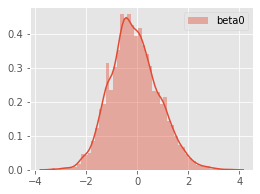

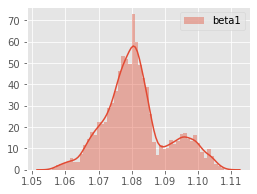

ValueError: color kwarg must have one color per data set. 2 data sets and 1 colors were provided

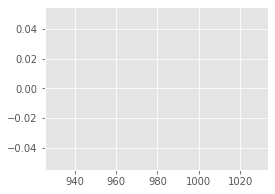

In [11]:
nodes = ["beta", "tau", "sigma"]
for node in nodes:
  if node == "beta":
    for i in range(2):
      plt.figure(figsize=(4,3))
      sns.distplot(hmc_samples[node][:,i], label=node+"%d"%i)
      plt.legend()
    plt.show()
  else:
    plt.figure(figsize=(4,3))
    sns.distplot(hmc_samples[node], label=node)
    plt.legend()
    plt.show()

In [ ]:
y_hat = hmc_samples["y_pred"].mean(axis=0)
y_std = hmc_samples["y_pred"].std(axis=0)

In [ ]:
y_pred_025 = y_hat - 1.96*y_std
y_pred_975 = y_hat + 1.96*y_std

In [ ]:
plt.plot(idx_train, y_train, "b-")
plt.plot(idx_test, y_test, "bx")
plt.plot(idx_test, y_hat[:-1], "r-")
plt.plot(idx_test, y_pred_025[:-1], "r--")
plt.plot(idx_test, y_pred_975[:-1], "r--")
plt.fill_between(idx_test, y_pred_025[:-1], y_pred_975[:-1], alpha=0.3)
plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.show()

In [ ]:
hmc_samples['W'].mean(axis=0)